In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image
from IPython.display import display

In [2]:
img_files = ['divleague_crop.png', 'divleague2_crop.png']

## Load and preprocess cropped area

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


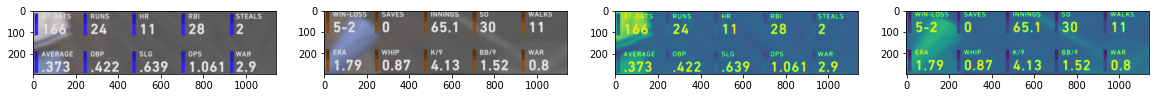

In [3]:
def preprocess_img(img_filename):
    img = cv2.imread(img_filename)
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_bw = cv2.medianBlur(img_bw, 5)
    return img, img_bw

img1, img1_proc = preprocess_img(img_files[0])
img2, img2_proc = preprocess_img(img_files[1])

def plot(images):
    plt.figure(figsize=(20,10))
    columns = len(images)
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        
plot([img1, img2, img1_proc, img2_proc])

## Threshold to find characters

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


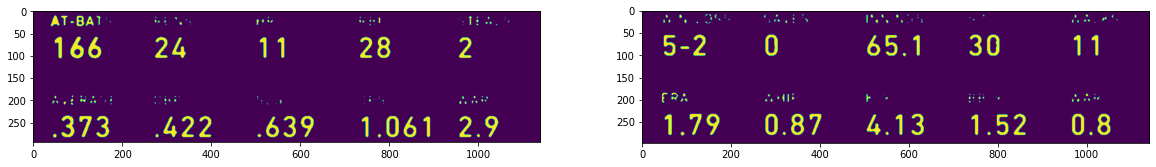

In [4]:
_, img1_thresh = cv2.threshold(img1_proc, 210, 255, cv2.THRESH_BINARY)
_, img2_thresh = cv2.threshold(img2_proc, 210, 255, cv2.THRESH_BINARY)
plot([img1_thresh, img2_thresh])

## Find characters as connected components and find text lines for numbers 

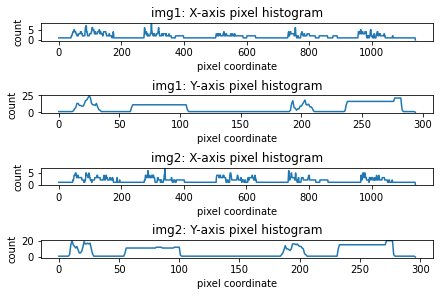

In [5]:
def get_numbers_bbox(img):
    ret, img_label = cv2.connectedComponents(img)
    labels = np.unique(img_label)
    boxes = []
    for label in labels:
        y, x = np.where(img_label == label)  # row (y), col (x)
        min_y = np.min(y)
        min_x = np.min(x)
        max_y = np.max(y)
        max_x = np.max(x)
        box_h_diff = np.abs(max_y - min_y)
        box_w_diff = np.abs(max_x - min_x)
        boxes.append([min_x, min_y, max_x, max_y])

    height, width = img.shape
    hist_x = np.zeros(width)
    hist_y = np.zeros(height)        
    for bbox in boxes:
        hist_x[bbox[0]: bbox[2]] += 1
        hist_y[bbox[1]: bbox[3]] += 1
    
    return boxes, hist_x, hist_y

bbox1, hist1_x, hist1_y = get_numbers_bbox(img1_thresh)
bbox2, hist2_x, hist2_y = get_numbers_bbox(img2_thresh)

fig, axs = plt.subplots(4, constrained_layout=True)
axs[0].set_title('img1: X-axis pixel histogram')
axs[0].set(xlabel='pixel coordinate', ylabel='count')
axs[1].set_title('img1: Y-axis pixel histogram')
axs[1].set(xlabel='pixel coordinate', ylabel='count')
axs[0].plot(np.arange(len(hist1_x)), hist1_x)
axs[1].plot(np.arange(len(hist1_y)), hist1_y)

axs[2].set_title('img2: X-axis pixel histogram')
axs[2].set(xlabel='pixel coordinate', ylabel='count')
axs[3].set_title('img2: Y-axis pixel histogram')
axs[3].set(xlabel='pixel coordinate', ylabel='count')
axs[2].plot(np.arange(len(hist2_x)), hist2_x)
axs[3].plot(np.arange(len(hist2_y)), hist2_y)
plt.show()

In [6]:
height, width = img1_thresh.shape
top_y1, top_y2 = 50 / height, 120 / height
bottom_y1, bottom_y2 = 225 / height, height / height

print(top_y1, top_y2, bottom_y1, bottom_y2)

0.1694915254237288 0.4067796610169492 0.7627118644067796 1.0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


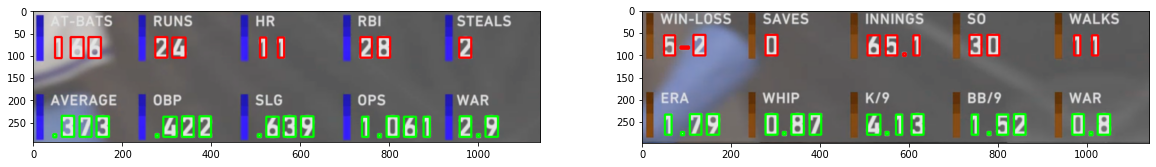

In [7]:
def filter_rows(bboxes, height, top_y1, top_y2, bottom_y1, bottom_y2):
    if len(bboxes) > 0:
        top_row = []
        bottom_row = []

        # Filter for row by heuristic of pixels
        for bbox in bboxes:
            y1, y2 = bbox[1] / height, bbox[3] / height
            if y1 > top_y1 and y1 < top_y2 and y2 > top_y1 and y2 < top_y2:
                top_row.append(bbox)
            if y1 > bottom_y1 and y1 < bottom_y2 and y2 > bottom_y1 and y2 < bottom_y2:
                bottom_row.append(bbox)
        top_row.sort(key=lambda x:x[0])
        bottom_row.sort(key=lambda x:x[0])

    return top_row, bottom_row

chars1 = filter_rows(bbox1, img1_thresh.shape[0], top_y1, top_y2, bottom_y1, bottom_y2)
chars2 = filter_rows(bbox2, img2_thresh.shape[0], top_y1, top_y2, bottom_y1, bottom_y2)

def plot_bbox(img_orig, rows):
    img = img_orig.copy()
    top_row, bottom_row = rows
    for bbox in top_row:
        img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), thickness=3)
    for bbox in bottom_row:
        img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), thickness=3)
    return img

img1_rect = plot_bbox(img1, chars1)
img2_rect = plot_bbox(img2, chars2)
plot([img1_rect, img2_rect])

## Create classifier for characters

In [8]:
h_reg = 10
w_reg = 3

def get_features(img):
    h, w = img.shape
    img = img / 255.
    
    h_win = int(h / h_reg)
    w_win = int(w / w_reg)
    div = (h_win * w_win)
    thresh_region = 0.6

    feat_ratio = h / w
    feat_regions = []
    for y in range(h_reg):
        for x in range(w_reg):
            win = img[y * h_win: (y+1) * h_win, x * w_win: (x+1) * w_win]
            occ_ratio = np.sum(win)
            occ_ratio /= div
            if occ_ratio >= thresh_region:
                feat_regions.append(1.)
            else:
                feat_regions.append(-1.)

    return [feat_ratio, *feat_regions]

train_files = glob.glob(os.path.join('data', 'train', '*.png'))
class_list = []
feat_mat = []
for train_file in train_files:
    img = cv2.imread(train_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    feat = get_features(img)
    char_class = train_file.split('/')[-1].split('.')[0]
    class_list.append(char_class)
    feat_mat.append(feat[1:])
    print(char_class, feat[0])

0 1.7037037037037037
1 3.2142857142857144
2 1.7037037037037037
3 1.7037037037037037
4 1.5
5 1.8
6 1.6071428571428572
7 1.7692307692307692
8 1.6428571428571428
9 1.6428571428571428
dash 0.2631578947368421
decimal 1.0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
for c, f in zip(class_list, feat_mat):
    print(c)
    display(np.array(f).reshape(h_reg, w_reg))

0


array([[-1.,  1., -1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.]])

1


array([[-1., -1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.]])

2


array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [ 1., -1., -1.]])

3


array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1.,  1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [ 1., -1.,  1.]])

4


array([[-1., -1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1.,  1.,  1.],
       [-1.,  1.,  1.]])

5


array([[ 1.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1.,  1., -1.],
       [ 1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1., -1.],
       [-1., -1.,  1.],
       [ 1., -1.,  1.]])

6


array([[-1., -1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.]])

7


array([[ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1.,  1.],
       [-1., -1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]])

8


array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [-1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.]])

9


array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.],
       [ 1.,  1.,  1.],
       [-1.,  1.,  1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1.,  1., -1.]])

dash


array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

decimal


array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

In [10]:
feat_mat_classes = [0, 2, 3, 4, 5, 6, 7, 8, 9]
subset_numbers_feat_map = np.array([feat_mat[i] for i in feat_mat_classes])
for c, f in zip(feat_mat_classes, subset_numbers_feat_map):
    print(c)
    print(np.array(f))
with open('digit_feat_map.npy', 'wb') as f:
    np.savez(f, feat_mat_classes=feat_mat_classes, feat_mat=subset_numbers_feat_map)

0
[-1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.
  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.]
2
[-1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.]
3
[-1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1.]
4
[-1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.]
5
[ 1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.]
6
[-1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.]
7
[ 1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.]
8
[-1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.
  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.]


In [11]:
import classify

char_classifier = classify.CharClassifier('digit_feat_map.npy')

test_files = glob.glob(os.path.join('chars', '*', '*.png'))
for test_file in test_files:
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    actual_char_class = test_file.split('/')[1]
    if actual_char_class == 'dash':
        actual_char_class = '-'
    if actual_char_class == 'dot':
        actual_char_class = '.'
    predicted_class = char_classifier.classify(img)
    
    print(test_file, actual_char_class == predicted_class)

chars/0/24.png True
chars/0/33.png True
chars/0/39.png True
chars/0/46.png True
chars/0/58.png True
chars/1/0.png True
chars/1/22.png True
chars/1/26.png True
chars/1/37.png True
chars/1/40.png True
chars/1/41.png True
chars/1/42.png True
chars/1/5.png True
chars/1/52.png True
chars/1/54.png True
chars/1/6.png True
chars/2/16.png True
chars/2/17.png True
chars/2/27.png True
chars/2/3.png True
chars/2/32.png True
chars/2/57.png True
chars/2/7.png True
chars/2/9.png True
chars/3/11.png True
chars/3/13.png True
chars/3/20.png True
chars/3/38.png True
chars/3/53.png True
chars/4/15.png True
chars/4/4.png True
chars/4/50.png True
chars/5/30.png True
chars/5/35.png True
chars/5/56.png True
chars/6/1.png True
chars/6/19.png True
chars/6/2.png True
chars/6/25.png True
chars/6/34.png True
chars/7/12.png True
chars/7/44.png True
chars/7/49.png True
chars/8/48.png True
chars/8/60.png True
chars/8/61.png True
chars/8/8.png True
chars/9/21.png True
chars/9/29.png True
chars/9/45.png True
chars/dash

## Find heuristic to separate chars into groups

In [16]:
for row in chars1:
    tmp_row = []
    bbox = row[0]
    cur = [char_classifier(img1_thresh[bbox[1]: bbox[3], bbox[0]: bbox[2]])]
    last = row[0][2]
    for bbox in row[1:]:
        char_class = char_classifier(img1_thresh[bbox[1]: bbox[3], bbox[0]: bbox[2]])
        dist = bbox[0] - last
        print(char_class, dist)
        if not cur or dist < 40:
            cur.append(char_class)
        else:
            tmp_row.append(str(''.join(cur)))
            cur = [char_class]
        last = bbox[2]
        if char_class == '-':
            hitter = False
    cur.append(char_class)
    tmp_row.append(str(''.join(cur)))
    print(tmp_row)
print (40 / i)

6 20
6 11
2 122
4 11
1 167
1 26
2 171
8 13
2 155
['166', '24', '11', '28', '22']
3 12
7 12
3 11
. 105
4 11
2 12
2 13
. 105
6 12
3 11
9 12
1 109
. 22
0 13
6 12
1 17
2 67
. 13
9 13
['.373', '.422', '.639', '1.061', '2.99']
